<a href="https://colab.research.google.com/github/tombackert/CS411-ml-for-ds/blob/main/MNIST_NN_tensorflow_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a neural network on MNIST with Keras

This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime

## Step 1: Create your input pipeline

Start by building an efficient input pipeline using advices from:
* The [Performance tips](https://www.tensorflow.org/datasets/performances) guide
* The [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance#optimize_performance) guide


### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# this is for tensorboard
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#model training
history = model.fit(
    ds_train,
    epochs=40,
    validation_data=ds_test,
    # callbacks=[tensorboard_callback]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 2.0478 - sparse_categorical_accuracy: 0.3037 - val_loss: 1.0442 - val_sparse_categorical_accuracy: 0.7646
Epoch 2/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8820 - sparse_categorical_accuracy: 0.7987 - val_loss: 0.5239 - val_sparse_categorical_accuracy: 0.8741
Epoch 3/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5030 - sparse_categorical_accuracy: 0.8755 - val_loss: 0.3897 - val_sparse_categorical_accuracy: 0.8983
Epoch 4/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3895 - sparse_categorical_accuracy: 0.8991 - val_loss: 0.3330 - val_sparse_categorical_accuracy: 0.9101
Epoch 5/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3371 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.3001 - val_sparse_categorical_accuracy: 0.9173
Epoch 6/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3041 - sparse_categorical_accuracy: 0.9180 - val_loss: 0.2782 - val_sparse_categorical_accuracy: 0.9210
Epoch 7/40
46

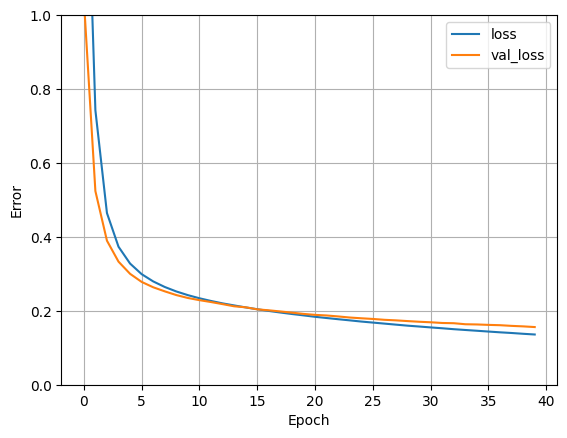

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
#simple evaluation method
scores = model.evaluate (ds_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1574 - sparse_categorical_accuracy: 0.9514


In [ ]:
scores

[0.15600724518299103, 0.9523000121116638]

In [ ]:
test_images, test_labels = next(iter(ds_test.take(1)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


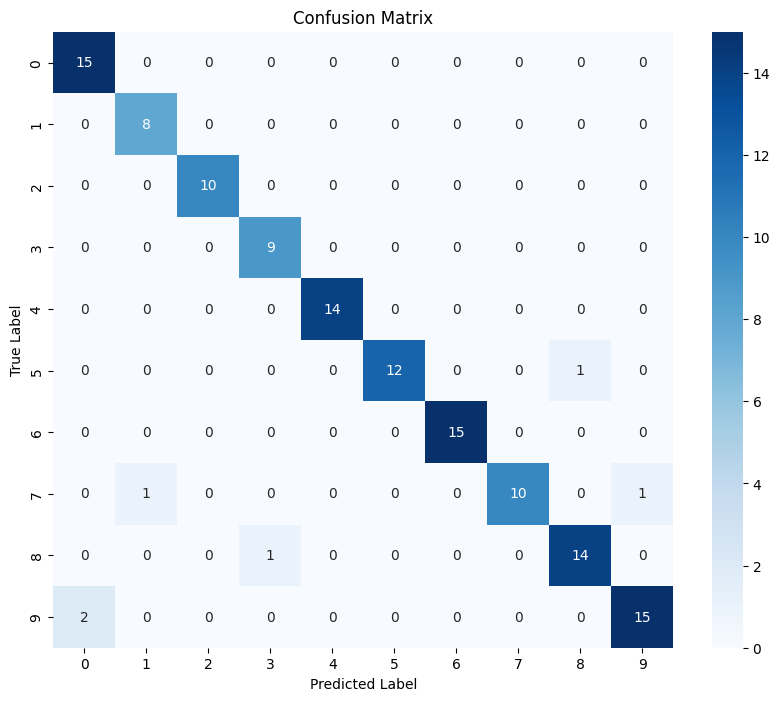

In [ ]:
predicted_probabilities = model.predict(test_images)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()